In [30]:
# %reset -f
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from torch import nn
from itertools import product as cartesian_prod
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


# np.random.seed(45671)
np.set_printoptions(precision=4, suppress=True)
# torch.manual_seed(17654)
def dectobin(decimal, num_bits):
    temp = bin(decimal)[2:]
    num_bits_actual = len(temp)
    return '0'*(num_bits-num_bits_actual)+temp

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

class DLGN_FC(nn.Module):
    def __init__(self, num_hidden_layers=0, input_dim=2, output_dim=1, num_hidden_nodes=[], beta=20, mode='pwc'):
        super(DLGN_FC, self).__init__()
        self.gating_layers=[]
        self.value_layers=[]
        self.num_hidden_layers = num_hidden_layers
        self.beta=beta  # Soft gating parameter
        self.mode = mode
        self.num_nodes=[input_dim]+num_hidden_nodes+[output_dim]
        for i in range(num_hidden_layers+1):
            self.gating_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1]))
            self.value_layers.append(nn.Linear(self.num_nodes[i], self.num_nodes[i+1]))
#             self.value_layers[-1].bias.data = torch.zeros(self.value_layers[-1].bias.data.shape)

    def return_gating_functions(self):
        effective_weights = []
        effective_biases =[]
        for i in range(self.num_hidden_layers):
            curr_weight = self.gating_layers[i].weight
            curr_bias = self.gating_layers[i].bias
            if i==0:
                effective_weights.append(curr_weight)
                effective_biases.append(curr_bias)
            else:
                effective_biases.append(torch.matmul(curr_weight,effective_biases[-1])+curr_bias)
                effective_weights.append(torch.matmul(curr_weight,effective_weights[-1]))
        return effective_weights, effective_biases
        # effective_weights (and effective biases) is a list of size num_hidden_layers
                

    def forward(self, x):
        gate_scores=[x]
        if self.mode=='pwc':
            values=[torch.ones(x.shape)]
        else:
            values=[x]
        
        for i in range(self.num_hidden_layers):
            gate_scores.append(self.gating_layers[i](gate_scores[-1]))
            curr_gate_on_off = torch.sigmoid(self.beta*gate_scores[-1])
            values.append(self.value_layers[i](values[-1])*curr_gate_on_off)

        values.append(self.value_layers[self.num_hidden_layers](values[-1]))
        
        # Values is a list of size 1+num_hidden_layers+1
        #gate_scores is a list of size 1+num_hidden_layers
        return values,gate_scores

Using cpu device


In [47]:
num_hidden_nodes=[2,3,4]
beta=100
num_hidden_layers=3
input_dim=2
output_dim=1
DLGN_obj= DLGN_FC(num_hidden_layers=num_hidden_layers,
                     input_dim=input_dim,
                     output_dim=output_dim,
                     num_hidden_nodes=num_hidden_nodes, 
                     beta=beta)

In [48]:
effective_weights, effective_biases = DLGN_obj.return_gating_functions()


In [49]:
for j in range(num_hidden_layers):
    print("=======weight=========")
    print(DLGN_obj.gating_layers[j].weight)
    print("=======bias=========")    
    print(DLGN_obj.gating_layers[j].bias)
    print("================")

# Technically the last gating layer params play no part in the model output.




=======weight=========
Parameter containing:
tensor([[-0.2757,  0.3176],
        [-0.1542,  0.4651]], requires_grad=True)
=======bias=========
Parameter containing:
tensor([-0.4262,  0.5093], requires_grad=True)
=======weight=========
Parameter containing:
tensor([[ 0.5744, -0.6092],
        [-0.1742, -0.3768],
        [-0.4246,  0.6902]], requires_grad=True)
=======bias=========
Parameter containing:
tensor([ 0.6028, -0.2373,  0.3874], requires_grad=True)
=======weight=========
Parameter containing:
tensor([[-0.4465, -0.0894, -0.1710],
        [-0.4665, -0.4154,  0.4017],
        [ 0.5067, -0.0653,  0.4318],
        [ 0.5551,  0.1565,  0.3002]], requires_grad=True)
=======bias=========
Parameter containing:
tensor([-0.0224,  0.3885,  0.3661, -0.4355], requires_grad=True)


In [50]:
for j in range(num_hidden_layers+1):
    print("=======weight=========")
    print(DLGN_obj.value_layers[j].weight)
    print("================")    
    print(DLGN_obj.value_layers[j].bias)
    print("=========bias=======")



=======weight=========
Parameter containing:
tensor([[ 0.3410,  0.0669],
        [ 0.6855, -0.4686]], requires_grad=True)
Parameter containing:
tensor([-0.4268,  0.6421], requires_grad=True)
=========bias=======
=======weight=========
Parameter containing:
tensor([[-0.5420,  0.4837],
        [ 0.1941,  0.3944],
        [-0.1355, -0.2264]], requires_grad=True)
Parameter containing:
tensor([-0.0208,  0.2362,  0.1571], requires_grad=True)
=========bias=======
=======weight=========
Parameter containing:
tensor([[-0.4877, -0.3609,  0.5367],
        [ 0.4240, -0.4786,  0.3916],
        [-0.4402, -0.4535, -0.4655],
        [ 0.0267,  0.3881,  0.3067]], requires_grad=True)
Parameter containing:
tensor([ 0.4625, -0.5128, -0.5449,  0.3402], requires_grad=True)
=========bias=======
=======weight=========
Parameter containing:
tensor([[-0.2264,  0.3890,  0.0251, -0.0270]], requires_grad=True)
Parameter containing:
tensor([0.3174], requires_grad=True)
=========bias=======


In [51]:
for weight, bias in zip(effective_weights, effective_biases):
    print("=======weight=========")    
    print(weight)
    print('=====bias======')
    print(bias)
    print('===========')

=======weight=========
Parameter containing:
tensor([[-0.2757,  0.3176],
        [-0.1542,  0.4651]], requires_grad=True)
=====bias======
Parameter containing:
tensor([-0.4262,  0.5093], requires_grad=True)
=======weight=========
tensor([[-0.0644, -0.1009],
        [ 0.1061, -0.2306],
        [ 0.0106,  0.1862]], grad_fn=<MmBackward0>)
=====bias======
tensor([ 0.0477, -0.3549,  0.9199], grad_fn=<AddBackward0>)
=======weight=========
tensor([[ 0.0175,  0.0338],
        [-0.0098,  0.2176],
        [-0.0350,  0.0443],
        [-0.0160, -0.0362]], grad_fn=<MmBackward0>)
=====bias======
tensor([-0.1693,  0.8832,  0.8106, -0.1885], grad_fn=<AddBackward0>)


In [52]:
test_input = torch.tensor([[0.,0.],[0.,1.],[1.,0.],[-1.,0],[0.,-1.],[1.,1.],[-1.,-1]])
activations,gate_scores = DLGN_obj(test_input) 

In [53]:
gate_scores

[tensor([[ 0.,  0.],
         [ 0.,  1.],
         [ 1.,  0.],
         [-1.,  0.],
         [ 0., -1.],
         [ 1.,  1.],
         [-1., -1.]]),
 tensor([[-0.4262,  0.5093],
         [-0.1086,  0.9744],
         [-0.7020,  0.3550],
         [-0.1505,  0.6635],
         [-0.7438,  0.0441],
         [-0.3843,  0.8202],
         [-0.4681,  0.1984]], grad_fn=<AddmmBackward0>),
 tensor([[ 0.0477, -0.3549,  0.9199],
         [-0.0532, -0.5855,  1.1061],
         [-0.0167, -0.2488,  0.9305],
         [ 0.1121, -0.4610,  0.9093],
         [ 0.1486, -0.1243,  0.7337],
         [-0.1177, -0.4793,  1.1167],
         [ 0.2130, -0.2305,  0.7231]], grad_fn=<AddmmBackward0>),
 tensor([[-0.1693,  0.8832,  0.8106, -0.1885],
         [-0.1354,  1.1008,  0.8550, -0.2247],
         [-0.1518,  0.8734,  0.7757, -0.2045],
         [-0.1867,  0.8929,  0.8456, -0.1725],
         [-0.2031,  0.6655,  0.7663, -0.1523],
         [-0.1180,  1.0910,  0.8200, -0.2407],
         [-0.2206,  0.6753,  0.8013, -0.1363

In [54]:
activations

[tensor([[1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.],
         [1., 1.]]),
 tensor([[-5.8324e-21,  8.5900e-01],
         [-3.6389e-07,  8.5900e-01],
         [-6.1693e-33,  8.5900e-01],
         [-5.5139e-09,  8.5900e-01],
         [-9.3481e-35,  8.4871e-01],
         [-3.8491e-19,  8.5900e-01],
         [-8.8376e-23,  8.5900e-01]], grad_fn=<MulBackward0>),
 tensor([[ 3.9143e-01,  2.2187e-16, -3.7336e-02],
         [ 1.9172e-03,  2.1490e-26, -3.7336e-02],
         [ 6.2305e-02,  9.0292e-12, -3.7336e-02],
         [ 3.9474e-01,  5.4520e-21, -3.7336e-02],
         [ 3.8977e-01,  2.2745e-06, -3.5008e-02],
         [ 3.0651e-06,  8.7456e-22, -3.7336e-02],
         [ 3.9475e-01,  5.6288e-11, -3.7336e-02]], grad_fn=<MulBackward0>),
 tensor([[ 1.1203e-08, -3.6143e-01, -6.9983e-01,  2.2115e-09],
         [ 5.7926e-07, -5.2657e-01, -5.2838e-01,  5.7344e-11],
         [ 1.0524e-07, -5.0097e-01, -5.5496e-01,  4.3605e-10],
         [ 1.94

In [55]:
X,Y = np.meshgrid(np.arange(-5,5.01,0.1),np.arange(-5,5.01,0.1))
X = np.array(X, dtype='float32')
Y = np.array(Y, dtype='float32')

data_test = np.concatenate((X.reshape((-1,1)), Y.reshape((-1,1)) ),axis=1)
test_input = torch.tensor(data_test)
activations,gate_scores = DLGN_obj(test_input) 

In [56]:
preds = activations[-1].data.numpy().reshape(X.shape)

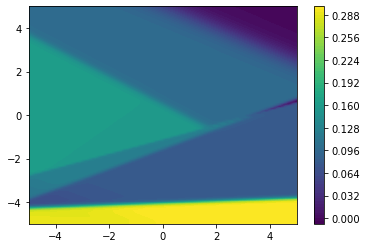

In [57]:
plt.contourf(X,Y,preds, levels=100)
plt.colorbar()

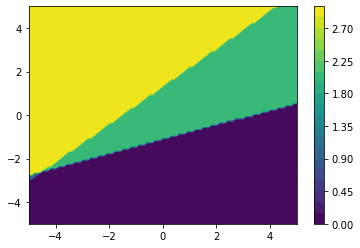

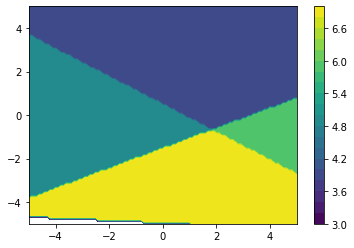

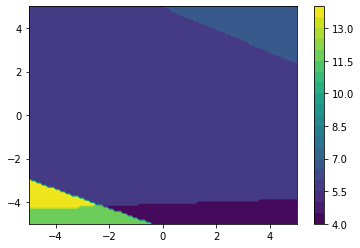

In [58]:
effective_weights, effective_biases = DLGN_obj.return_gating_functions()

gating_pattern_list=[]
for j in range(num_hidden_layers):
    Z_all = np.zeros(X.shape)
    for i in range( num_hidden_nodes[j]):
        weight = effective_weights[j][i].data.numpy()
        bias = effective_biases[j][i].data.numpy()
        Z = (np.dot(weight,data_test.T)+bias)>0
        Z = Z.reshape(X.shape)
        Z_all+= (2**i)*Z
    gating_pattern_list.append(Z_all)
#     plt.figure()
#     plt.contourf(X,Y,Z,levels=20)
#     plt.colorbar()
for j in range(num_hidden_layers):    
    plt.figure()
    plt.contourf(X,Y,gating_pattern_list[j],levels=20)
    plt.colorbar()


In [59]:

complete_path_vals = np.zeros(tuple(num_hidden_nodes))
partial_path_vals_list=[]
for j in range(num_hidden_layers):
    partial_path_vals_list.append(np.zeros(tuple(num_hidden_nodes[j:])))

    

complete_paths = list(cartesian_prod(*[range(x) for x in num_hidden_nodes]))
partial_paths_list=[]

for j in range(num_hidden_layers):
    partial_paths_list.append(list(cartesian_prod(*[list(range(x)) for x in num_hidden_nodes[j:]])))

    
for path in complete_paths:
    temp = np.dot(DLGN_obj.value_layers[0].weight.data.numpy()[path[0],:], np.ones(input_dim))
    for k in range(1,num_hidden_layers):
        temp *= DLGN_obj.value_layers[k].weight.data.numpy()[path[k], path[k-1]]
    temp *= DLGN_obj.value_layers[num_hidden_layers].weight.data.numpy()[0, path[-1]]
    complete_path_vals[path]=temp
        

for j in range(num_hidden_layers):
    for path in partial_paths_list[j]:
        temp = DLGN_obj.value_layers[j].bias.data.numpy()[path[0]]
        for k in range(j+1,num_hidden_layers):
#             temp *= DLGN_obj.value_layers[k].weight.data.numpy()[path[k], path[k-1]]
            temp *= DLGN_obj.value_layers[k].weight.data.numpy()[path[k-j], path[k-1-j]]            
        temp *= DLGN_obj.value_layers[num_hidden_layers].weight.data.numpy()[0, path[-1]]        
        partial_path_vals_list[j][path]=temp


In [63]:
# print(partial_paths_list)
# print(partial_path_vals_list)
print(complete_paths)
print(complete_path_vals)


[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3)]
[[[-0.0244 -0.0365  0.0024  0.0002]
  [ 0.0065 -0.0147 -0.0009 -0.0008]
  [ 0.0067 -0.0084  0.0006  0.0005]]

 [[ 0.0116  0.0173 -0.0012 -0.0001]
  [ 0.007  -0.0159 -0.001  -0.0009]
  [ 0.006  -0.0075  0.0006  0.0004]]]


In [64]:
# This makes sense only for 2D-input


val_pwc_apx = np.zeros(X.shape)


for i in range(len(X)):
    for j in range(len(X[0])):
        input_test = np.array([X[i,j], Y[i,j]])
        for path in complete_paths:
            pos_activ=1
            for l,k in enumerate(path):
                gating_score = np.dot(effective_weights[l].data.numpy(),input_test)[k]+\
                                effective_biases[l].data.numpy()[k]
                if gating_score<0:
                    pos_activ=0
                    break # This path is not active
            val_pwc_apx[i,j] += pos_activ*complete_path_vals[path]
        
        for start in range(num_hidden_layers):
            for path in partial_paths_list[start]:
                pos_activ=1
                for layer,k in enumerate(path):
                    gating_score = np.dot(effective_weights[start+layer].data.numpy(),input_test)[k]+ \
                                    effective_biases[start+layer].data.numpy()[k]
                    if gating_score<0:
                        pos_activ=0
                        break # This path is not active
                val_pwc_apx[i,j] += pos_activ*partial_path_vals_list[start][path]
                
        val_pwc_apx[i,j] += DLGN_obj.value_layers[num_hidden_layers].bias[0]        

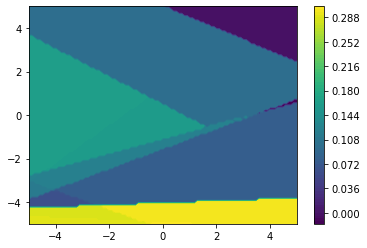

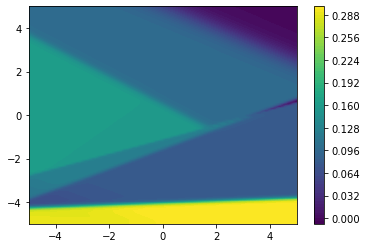

In [65]:
plt.contourf(X,Y,val_pwc_apx,levels=100)
plt.colorbar()

plt.figure()
plt.contourf(X,Y,preds,levels=100)
plt.colorbar()

In [18]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.size = len(Y)
        self.x = torch.tensor(X)
        self.y = torch.tensor(Y)

    def __len__(self):
        return (self.size)

    def __getitem__(self, idx):
        #print(self.x[idx].shape,self.y[idx].shape )
        return self.x[idx].float(), self.y[idx].float()

In [19]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0
    for batch, (x,y) in enumerate(dataloader):
        X, y = x.to(device), y.to(device)
        activations, gate_scores = model(X.float())
        loss = loss_fn(activations[-1], y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch%16 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} Batch:{batch} [{current:>5d}/{size:>5d}]")
    return pred

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred , out = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return pred, out


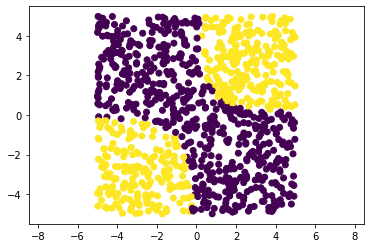

In [20]:
# data_gen 2dim
num_points = 1000

X_all = np.random.rand(num_points,2)*10-5.
y_all = np.sign(X_all[:,0]*X_all[:,1]-1.)

plt.axis('equal')
plt.scatter(X_all[:,0], X_all[:,1], c=y_all)

train_dataloader = DataLoader(CustomDataset(X_all, y_all), batch_size = num_points, shuffle = True)



In [21]:
parameters_curr=[]
parameters_curr += [DLGN_obj.gating_layers[i].weight for i in range(num_hidden_layers)]
parameters_curr += [DLGN_obj.gating_layers[i].bias for i in range(num_hidden_layers)]
parameters_curr += [DLGN_obj.value_layers[i].weight for i in range(num_hidden_layers+1)]
parameters_curr += [DLGN_obj.value_layers[i].bias for i in range(num_hidden_layers+1)]


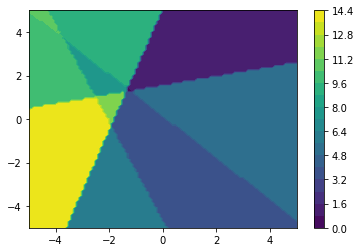

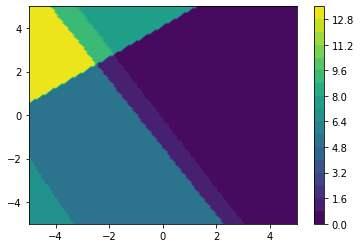

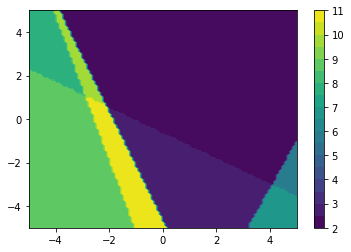

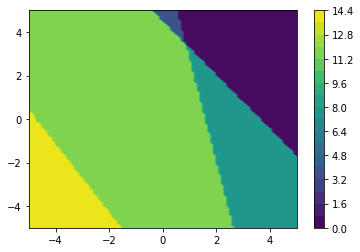

In [22]:
effective_weights, effective_biases = DLGN_obj.return_gating_functions()

gating_pattern_list=[]
for j in range(num_hidden_layers):
    Z_all = np.zeros(X.shape)
    for i in range( num_hidden_nodes[j]):
        weight = effective_weights[j][i].data.numpy()
        bias = effective_biases[j][i].data.numpy()
        Z = (np.dot(weight,data_test.T)+bias)>0
        Z = Z.reshape(X.shape)
        Z_all+= (2**i)*Z
    gating_pattern_list.append(Z_all)
#     plt.figure()
#     plt.contourf(X,Y,Z,levels=20)
#     plt.colorbar()
for j in range(num_hidden_layers):    
    plt.figure()
    plt.contourf(X,Y,gating_pattern_list[j],levels=20)
    plt.colorbar()


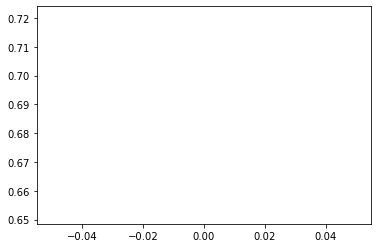

In [23]:

optimizer = torch.optim.Adam(parameters_curr, lr = 3e-3)  
loss_list=[]

for epoch in range(1):
    for batch, (x,y) in enumerate(train_dataloader):
        X_curr, y_curr = x.to(device), y.to(device)
        z = (y_curr.clone().detach()+1.)/2.
        activations, gate_scores = DLGN_obj(X_curr.float())
        model_preds = activations[-1][:,0]
        criterion = torch.nn.BCEWithLogitsLoss(reduction='mean')
        loss = criterion(model_preds, z)
        loss_list.append(loss.detach().numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
plt.plot(loss_list)

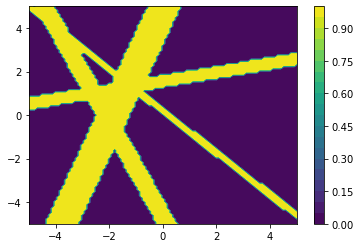

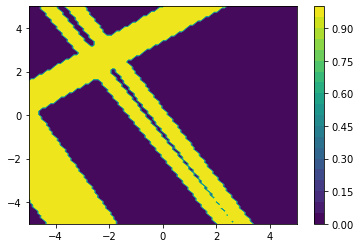

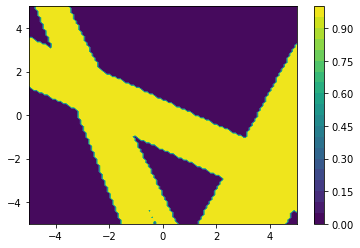

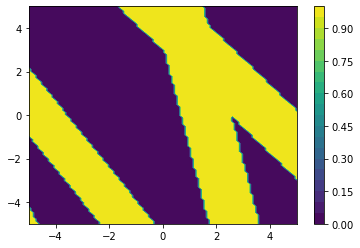

In [24]:
effective_weights, effective_biases = DLGN_obj.return_gating_functions()

gating_pattern_list=[]
for j in range(num_hidden_layers):
    Z_all = np.zeros(X.shape)
    for i in range( num_hidden_nodes[j]):
        weight = effective_weights[j][i].data.numpy()
        bias = effective_biases[j][i].data.numpy()
        Z = ((np.dot(weight,data_test.T)+bias)>-0.1)*((np.dot(weight,data_test.T)+bias)<0.1)
        Z = Z.reshape(X.shape)
        Z_all =  np.maximum(Z, Z_all)
    gating_pattern_list.append(Z_all)
#     plt.figure()
#     plt.contourf(X,Y,Z,levels=20)
#     plt.colorbar()
for j in range(num_hidden_layers):    
    plt.figure()
    plt.contourf(X,Y,gating_pattern_list[j],levels=20)
    plt.colorbar()
#     plt.scatter(X_all[:,0], X_all[:,1], c=y_all)




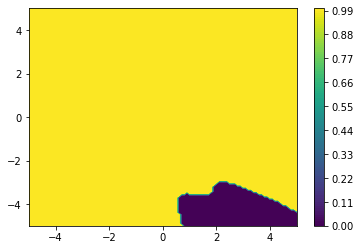

In [25]:
X,Y = np.meshgrid(np.arange(-5,5.01,0.1),np.arange(-5,5.01,0.1))
X = np.array(X, dtype='float32')
Y = np.array(Y, dtype='float32')

data_test = np.concatenate((X.reshape((-1,1)), Y.reshape((-1,1)) ),axis=1)
test_input = torch.tensor(data_test)
activations,gate_scores = DLGN_obj(test_input) 

preds = activations[-1].data.numpy().reshape(X.shape)

plt.contourf(X,Y,preds>0, levels=100)
plt.colorbar()





In [37]:
a=np.random.rand(10000)

In [38]:
a.shape

(10000,)

In [39]:
b=np.zeros(a.shape)
b[0]=a[0]
for j in range(1,len(a)):
    b[j]=np.min([b[j-1],a[j]])

In [40]:
a[0:10]

array([0.5876, 0.3786, 0.3799, 0.9676, 0.635 , 0.9979, 0.3848, 0.8882,
       0.2054, 0.3112])

In [41]:
b[0:10]

array([0.5876, 0.3786, 0.3786, 0.3786, 0.3786, 0.3786, 0.3786, 0.3786,
       0.2054, 0.2054])

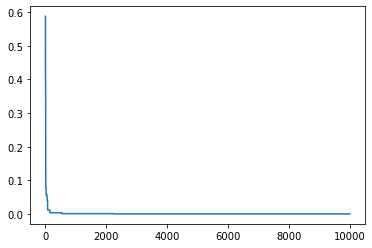

In [42]:
plt.plot(range(len(a)),b)
plt.plot(range(len(a))